In [11]:
'''
Create plots associated with Rugg et al. (2023)
Contact: Alex Rugg Stebbins (arugg@ucar.edu)

Note: this code will not always work properly if cells are run out of order.

Requirements: data must be contained within datadir with subdirectories:
"huc_domains", "metsim_setup", "vic_setup", "vic_output"
This data is available at https://gdex.ucar.edu/dataset/383_stebbins.html
 '''

import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from netCDF4 import Dataset as ds
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import string

datadir = '/glade/derecho/scratch/arugg/open_research/grl_2023'


/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/xesmf/frontend.py:718: UserWarning: Using dimensions ('y', 'x') from data variable data as the horizontal dimensions for the regridding.
  warnings.warn(
/glade/derecho/scratch/arugg/tmp/ipykernel_81917/238205831.py:142: RuntimeWarning: invalid value encountered in divide
  upscaled = (upscaled) / (justones_upscaled)


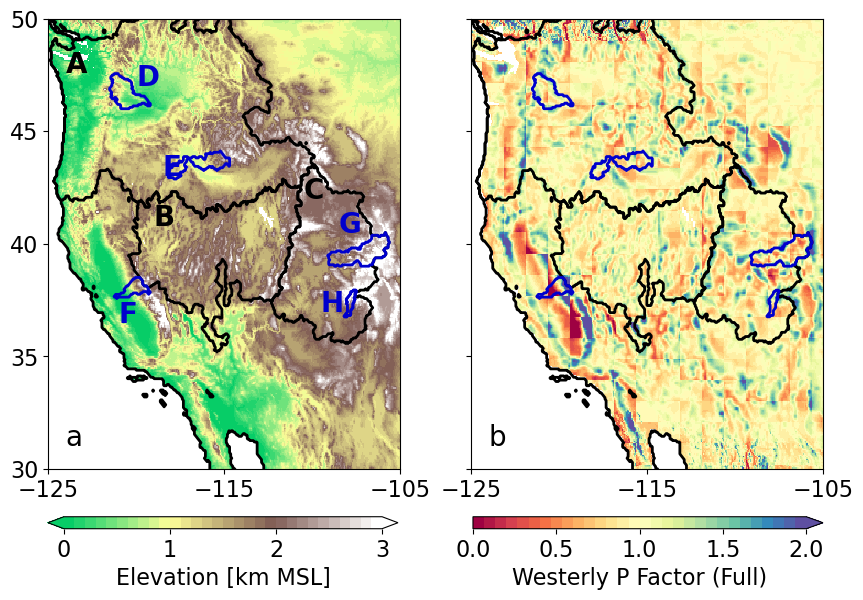

In [10]:
''' Figure One: Map of domain, topography, watersheds.'''

vicParams = xr.open_dataset(datadir +
                            '/metsim_setup/westConus_vic_parameters.nc')

# Read HUC data
watersheds = xr.open_dataset(datadir +
                             '/huc_domains/hucData02.nc').load()
huc02 = watersheds.data[48:448, 0:464]
lat = watersheds.lat[48:448, 0:464]
lon = watersheds.lon[48:448, 0:464]
watersheds = xr.open_dataset(datadir +
                             '/huc_domains/hucData08.nc').load()
huc08 = watersheds.data
huc12 = xr.open_dataset(datadir +
                        '/huc_domains/huc12_6km.nc')

# Regrid HUC12 data
lon_b = lon[0, :] - (0.0625) / 2
lon_b = np.append(lon_b, lon[0, lon.shape[1] - 2] + 0.0625 / 2)
lat_b = lat[:, 0] - (0.0625) / 2
lat_b = np.append(lat_b, lat[lat.shape[0]-2, 0] + 0.0625 / 2)
obsGrid = xr.Dataset(
    {'lat': (['lat'], lat.data[:, 0]), 'lon': (['lon'], lon.data[0, :]),
     'lat_b': (['lat_b'], lat_b), 'lon_b': (['lon_b'], lon_b)})

lon_b = (huc12.lon.data[0, 0:-1] + huc12.lon.data[0, 1:]) / 2
lon_b = np.append(
    huc12.lon.data[0, 0] - 0.5 *
    (huc12.lon.data[0, 1] - huc12.lon.data[0, 0]),
    lon_b)
lon_b = np.append(
    lon_b,
    huc12.lon.data[0, huc12.lon.shape[1] - 1] +
    0.5 * (huc12.lon.data[0, huc12.lon.shape[1] - 1] -
           huc12.lon.data[0, huc12.lon.shape[1] - 2]))
lat_b = (huc12.lat.data[0:-1, 0] + huc12.lat.data[1:, 0]) / 2
lat_b = np.append(
    huc12.lat.data[0, 0] - 0.5 *
    (huc12.lat.data[1, 0] - huc12.lat.data[0, 0]),
    lat_b)
lat_b = np.append(
    lat_b,
    huc12.lat.data[huc12.lat.shape[0] - 1, 0] +
    0.5 * (huc12.lat.data[huc12.lat.shape[0] - 1, 0] -
           huc12.lat.data[huc12.lat.shape[0] - 2, 0]))
huc12Grid = xr.Dataset(
    {'lat': (['lat'], huc12.lat.data[:, 0]),
     'lon': (['lon'], huc12.lon.data[0, :]),
     'lat_b': (['lat_b'], lat_b),
     'lon_b': (['lon_b'], lon_b)})
regridder = xe.Regridder(huc12Grid, obsGrid, 'nearest_s2d')
huc12 = regridder(huc12.data)
huc12 = huc12.values


def create_watershed_bools(huc, lower_bound, upper_bound):
    '''Create boolean array which is true inside the given bounds (+/- 0.5)
    and false elsewhere.

    huc: array with integers corresponding to huc codes
    lower_bound, upper_bound: floats corresponding to minimum and maximum
        values to set as true
    '''
    in_huc = np.ones(huc.shape)
    in_huc[huc < lower_bound - 0.5] = 0
    in_huc[huc > upper_bound + 0.5] = 0
    return in_huc


pacific = create_watershed_bools(huc02, 13, 13)
upperCo = create_watershed_bools(huc02, 12, 12)
greatBasin = create_watershed_bools(huc02, 21, 21)
cameo = create_watershed_bools(huc08, 14010000, 14010009)
tuolomne = create_watershed_bools(huc12, 180400095232, 180400095232)
yakima = create_watershed_bools(huc08, 17030000, 17030009)
animas = create_watershed_bools(huc08, 14080104, 14080104)
boise = create_watershed_bools(huc08, 17050110, 17050114)

# Create boolean for land using elevation
continents = np.zeros(pacific.shape)
continents[~np.isnan(vicParams.elev)] = 1
continents[pacific > 0.5] = True  # Some points lie below sea level
continents[greatBasin > 0.5] = True

# Map of VIC domain, topography, HUCs used
plt.rcParams.update({'font.size': 16})
tmp1 = plt.get_cmap('terrain', 40)
newcolors = tmp1(np.linspace(0, 1, 40))
cmap = ListedColormap(newcolors[10:, :])

# Plot domain and elevation
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True, sharex=True)
plt.subplots_adjust(bottom=0.2, top=0.95)
im = ax[0].pcolormesh(vicParams.lon, vicParams.lat, vicParams.elev / 1000,
                      vmin=0, vmax=3, cmap=cmap)
ax[0].set_xlim([-125, -105])
ax[0].set_ylim([30, 50])
ax[0].set_xticks([-125, -115, -105])
ax[0].set_yticks([30, 35, 40, 45, 50])
ax[0].text(-124, 31, 'a', color='k', fontsize=20)
for boundary in [continents, pacific, greatBasin, upperCo]:
    ax[0].contour(vicParams.lon, vicParams.lat, boundary,
                  levels=[0.5], colors='k', linewidths=2)
for boundary in [yakima, boise, tuolomne, cameo, animas]:
    ax[0].contour(vicParams.lon, vicParams.lat, boundary,
                  levels=[0.5], colors='mediumblue', linewidths=2)
ax[0].text(-124, 47.6, 'A', color='k', fontsize=20, fontweight='bold')
ax[0].text(-119, 40.8, 'B', color='k', fontsize=20, fontweight='bold')
ax[0].text(-110.5, 42, 'C', color='k', fontsize=20, fontweight='bold')
ax[0].text(-120, 47, 'D', color='mediumblue', fontsize=20, fontweight='bold')
ax[0].text(-118.5, 43, 'E', color='mediumblue', fontsize=20, fontweight='bold')
ax[0].text(-121, 36.5, 'F', color='mediumblue', fontsize=20, fontweight='bold')
ax[0].text(-108.5, 40.5, 'G', color='mediumblue', fontsize=20, fontweight='bold')
ax[0].contour(vicParams.lon, vicParams.lat, animas,
              levels=[0.5], colors='mediumblue', linewidths=2)
ax[0].text(-109.5, 37, 'H', color='mediumblue', fontsize=20, fontweight='bold')
cax2 = plt.axes([0.125, 0.1, 0.35, 0.02])
c2 = plt.colorbar(im, cax=cax2, extend='both', orientation='horizontal')
c2.set_label('Elevation [km MSL]')

# Compute precipitation adjustment with Westerly winds
topoData = xr.open_dataset(datadir + '/topoData.nc')
topoDif = topoData.topoHiRes - topoData.topoLoRes
maxElevDif100km = topoData.maxElev100km[4, :, :] - topoData.topoHiRes
minElevDif100km = topoData.minElev100km[4, :, :] - topoData.topoHiRes
minElevDif50km = topoData.minElev50km[4, :, :] - topoData.topoHiRes
wadjust = (1 - 0.000199 * maxElevDif100km + 0.000216 * minElevDif100km -
           0.000675 * minElevDif50km + 0.000557 * topoDif)

cesmGrid = xr.open_dataset(datadir + '/cesmGrid.nc')
obsGrid = xr.open_dataset(datadir + '/obsGrid.nc')
downscaler = xe.Regridder(cesmGrid, obsGrid, 'nearest_s2d')
upscaler = xe.Regridder(obsGrid, cesmGrid, 'conservative')

nonan = np.nan_to_num(wadjust, copy=True, nan=0.0)
upscaled = upscaler(nonan)
justones = np.ones(wadjust.shape)  # upscale array of ones to account for nan=0
justones[~np.isfinite(wadjust.values)] = 0
justones_upscaled = upscaler(justones)
upscaled = (upscaled) / (justones_upscaled)
newaverage = downscaler(upscaled)
newaverage = np.maximum(newaverage, 1e-12)  # avoid divide by zero error
wadjust = wadjust / newaverage

# Plot Westerly winds adjustment
im = ax[1].pcolormesh(wadjust.lon, wadjust.lat, wadjust, vmin=0, vmax=2,
                      cmap=plt.get_cmap('Spectral', 30))
ax[1].set_xlim([-125, -105])
ax[1].set_ylim([30, 50])
ax[1].set_xticks([-125, -115, -105])
ax[1].set_yticks([30, 35, 40, 45, 50])
ax[1].text(-124, 31, 'b', color='k', fontsize=20)
for boundary in [continents, pacific, greatBasin, upperCo]:
    ax[1].contour(vicParams.lon, vicParams.lat, boundary,
                  levels=[0.5], colors='k', linewidths=2)
for boundary in [yakima, boise, tuolomne, cameo, animas]:
    ax[1].contour(vicParams.lon, vicParams.lat, boundary,
                  levels=[0.5], colors='mediumblue', linewidths=2)
cax2 = plt.axes([0.55, 0.1, 0.35, 0.02])
c2 = plt.colorbar(im, cax=cax2, extend='max', orientation='horizontal')
c2.set_label('Westerly P Factor (Full)')
plt.savefig('ruggEtAl_GRL_fig1', dpi=150)


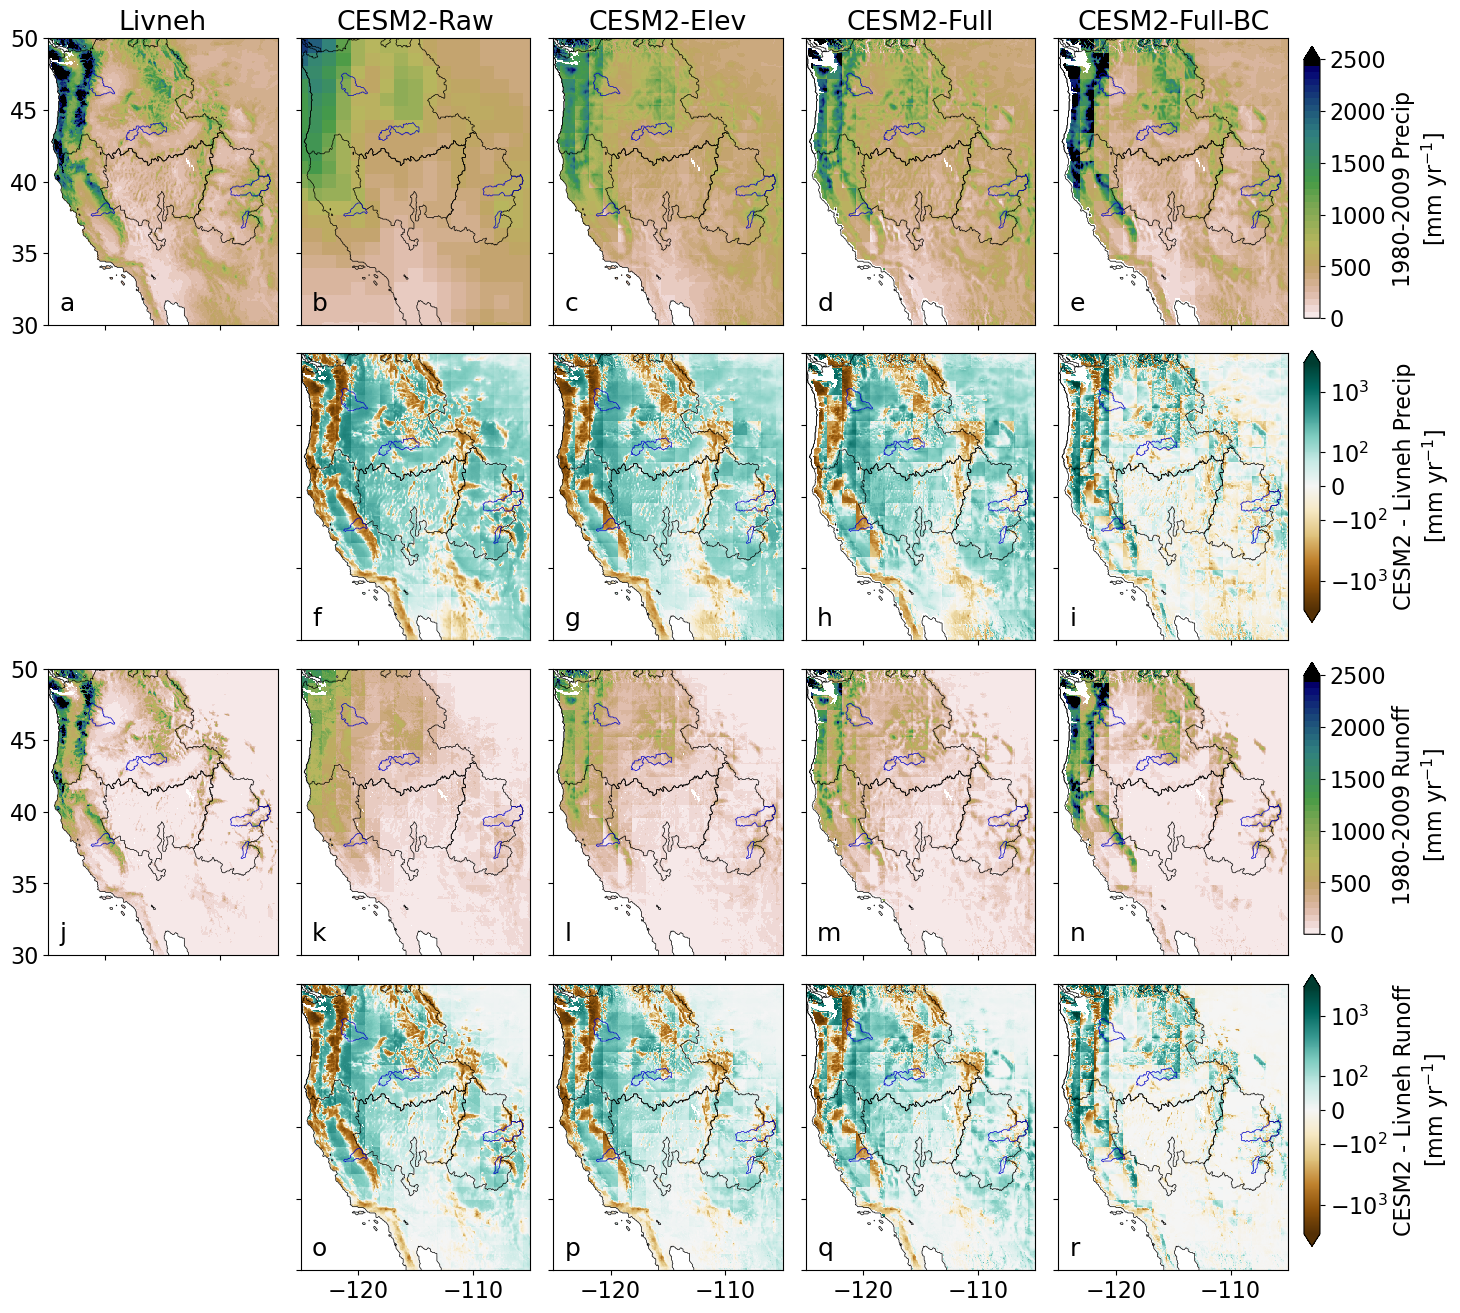

In [13]:
''' Figure 2: Annual Mean Precip, Runoff Maps'''

mpl.rcParams.update({'font.size': 16})
tmp1 = plt.get_cmap('gist_earth_r', 41)
newcolors = tmp1(np.linspace(0, 1, 41))
cmap = ListedColormap(newcolors[1:, :])

fig, axs = plt.subplots(4, 5, figsize=(16, 16), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Current Precip (top row)
cntl = xr.open_dataset(datadir +
       '/metsim_setup/LivnehForcing_4MetSim_1960-2009_CNTL.nc')
cesm = xr.open_dataset(datadir +
       '/metsim_setup/LivnehForcing_4MetSim_1960-2009_CESM-1231.001.nc')
elev = xr.open_dataset(datadir +
       '/metsim_setup/LivnehForcing_4MetSim_1960-2009_TOPO-1231.001.nc')
ds = xr.open_dataset(datadir +
       '/metsim_setup/LivnehForcing_4MetSim_1960-2009_DSMC-1231.001.nc')
dsbc = xr.open_dataset(datadir +
       '/metsim_setup/LivnehForcing_4MetSim_1960-2009_DSBC-1231.001.nc')
istart = 273 + 365 * 19  # Oct 1 of first year of averaging (1979)
iend = 18158  # Oct 1 of last year of averaging


def plot_precip(axs, col, data, reference):
    alphabet = string.ascii_lowercase

    mean_precip = np.mean(data.prec.values[istart:iend, :, :], axis=0) * 365
    im1 = axs[0, col].pcolormesh(
        data.lon, data.lat, mean_precip, shading='auto',
        norm=colors.Normalize(vmin=0, vmax=2500), cmap=cmap)
    axs[0, col].text(-124, 31, alphabet[col], fontsize=18)

    precip_dif = 365 * np.mean(data.prec.values[istart:iend, :, :] -
                               reference.prec.values[istart:iend, :, :],
                               axis=0)
    im2 = axs[1, col].pcolormesh(
        data.lon, data.lat, precip_dif, shading='auto',
        norm=colors.SymLogNorm(100, 0.5, vmin=-3000, vmax=3000),
        cmap='BrBG')
    axs[1, col].text(-124, 31, alphabet[4+col], fontsize=18)

    return im1, im2


im1, im2 = plot_precip(axs, 0, cntl, cntl)
plot_precip(axs, 1, cesm, cntl)
plot_precip(axs, 2, elev, cntl)
plot_precip(axs, 3, ds, cntl)
plot_precip(axs, 4, dsbc, cntl)

cax1 = plt.axes([0.91, 0.705, 0.01, 0.17])
c1 = plt.colorbar(im1, cax=cax1, extend='max', orientation='vertical')
c1.set_label('1980-2009 Precip\n[mm yr$^{-1}$]')

cax2 = plt.axes([0.91, 0.515, 0.01, 0.17])
c2 = plt.colorbar(im2, cax=cax2, extend='both', orientation='vertical')
c2.set_label('CESM2 - Livneh Precip\n[mm yr$^{-1}$]')

# Current Streamflow (3rd row)
cntl = xr.open_dataset(datadir + '/vic_output/seasonalMeans_1980-2009_CNTL.nc')
cesm = xr.open_dataset(datadir + '/vic_output/seasonalMeans_1980-2009_CESM.nc')
elev = xr.open_dataset(datadir + '/vic_output/seasonalMeans_1980-2009_TOPO.nc')
ds = xr.open_dataset(datadir + '/vic_output/seasonalMeans_1980-2009_DSMC.nc')
dsbc = xr.open_dataset(datadir + '/vic_output/seasonalMeans_1980-2009_DSBC.nc')


def plot_runoff(axs, col, data, reference):
    alphabet = string.ascii_lowercase

    im3 = axs[2, col].pcolormesh(data.lon, data.lat,
                                 data.STREAMFLOW.values[0, :, :] * 365,
                                 shading='auto', norm=colors.Normalize(
                                     vmin=0, vmax=2500),
                                 cmap=cmap)
    axs[2, col].text(-124, 31, alphabet[9+col], fontsize=18)

    im4 = axs[3, col].pcolormesh(data.lon, data.lat,
                                 (data.STREAMFLOW.values[0, :, :] -
                                  reference.STREAMFLOW.values[0, :, :]) * 365,
                                 shading='auto', norm=colors.SymLogNorm(
                                     100, 0.5, vmin=-3000, vmax=3000),
                                 cmap='BrBG')
    axs[3, col].text(-124, 31, alphabet[13+col], fontsize=18)

    return im3, im4


im3, im4 = plot_runoff(axs, 0, cntl, cntl)
plot_runoff(axs, 1, cesm, cntl)
plot_runoff(axs, 2, elev, cntl)
plot_runoff(axs, 3, ds, cntl)
plot_runoff(axs, 4, dsbc, cntl)

cax3 = plt.axes([0.91, 0.32, 0.01, 0.17])
c3 = plt.colorbar(im3, cax=cax3, extend='max', orientation='vertical')
c3.set_label('1980-2009 Runoff\n[mm yr$^{-1}$]')

cax4 = plt.axes([0.91, 0.125, 0.01, 0.17])
c4 = plt.colorbar(im4, cax=cax4, extend='both', orientation='vertical')
c4.set_label('CESM2 - Livneh Runoff\n[mm yr$^{-1}$]')

# Add axis labels, watershed outlines
axs[0, 0].set_title('Livneh')
axs[0, 1].set_title('CESM2-Raw')
axs[0, 2].set_title('CESM2-Elev')
axs[0, 3].set_title('CESM2-Full')
axs[0, 4].set_title('CESM2-Full-BC')

# Add region outlines
for i in [0, 1, 2, 3, 4]:
    for j in [0, 1, 2, 3]:
        for boundary in [continents, pacific, greatBasin, upperCo]:
            axs[j, i].contour(cntl.lon, cntl.lat, boundary,
                              levels=[0.5], colors='k', linewidths=0.5)
        for boundary in [yakima, boise, tuolomne, cameo, animas]:
            axs[j, i].contour(cntl.lon, cntl.lat, boundary,
                              levels=[0.5], colors='mediumblue', linewidths=0.5)
fig.delaxes(axs[1, 0])
fig.delaxes(axs[3, 0])
axs[0, 0].set_xlim([-125, -105])
axs[0, 0].set_ylim([30, 50])
axs[0, 0].set_xticks([-120, -110])
axs[0, 0].set_yticks([30, 35, 40, 45, 50])
plt.savefig('ruggEtAl_GRL_fig2', dpi=150)
